# 2021-12-01 Finite Volume methods

## Last time

* Notes on unstructured meshing workflow
* Finite volume methods for hyperbolic conservation laws
* Riemann solvers for scalar equations
  * Shocks and the Rankine-Hugoniot condition
  * Rarefactions and entropy solutions

## Today

* Higher order methods
* Godunov's Theorem
* Slope reconstruction
* Slope limiting

In [84]:
using LinearAlgebra
using Plots
default(linewidth=4)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

function testfunc(x)
    max(1 - 4*abs.(x+2/3),
        abs.(x) .< .2,
        (2*abs.(x-2/3) .< .5) * cospi(2*(x-2/3)).^2
    )
end

riemann_advection(uL, uR) = 1*uL # velocity is +1

function fv_solve1(riemann, u_init, n, tfinal=1)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        fluxL = riemann(u[idxL], u)
        fluxR = riemann(u, u[idxR])
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(
        rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

function riemann_burgers(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_burgers(uL[i])
        fR = flux_burgers(uR[i])
        flux[i] = if uL[i] > uR[i] # shock
            max(fL, fR)
        elseif uL[i] > 0 # rarefaction all to the right
            fL
        elseif uR[i] < 0 # rarefaction all to the left
            fR
        else
            0
        end
    end
    flux
end

function riemann_traffic(uL, uR)
    flux = zero(uL)
    for i in 1:length(flux)
        fL = flux_traffic(uL[i])
        fR = flux_traffic(uR[i])
        flux[i] = if uL[i] < uR[i] # shock
            min(fL, fR)
        elseif uL[i] < .5 # rarefaction all to the right
            fL
        elseif uR[i] > .5 # rarefaction all to the left
            fR
        else
            flux_traffic(.5)
        end
    end
    flux
end

riemann_traffic (generic function with 1 method)

# Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE can be at most first order accurate if they are monotone.

For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, 0) \ge 0 .$$

## Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

# Slope Reconstruction

One method for constructing higher order methods is to use the state in neighboring elements to perform a conservative reconstruction of a piecewise polynomial, then compute numerical fluxes by solving Riemann problems at the interfaces.  If $x_i$ is the center of cell $i$ and $g_i$ is the reconstructed gradient inside cell $i$, our reconstructed solution is
$$ \tilde u_i(x) = u_i + g_i \cdot (x - x_i) . $$
We would like this reconstruction to be monotone in the sense that
$$ \Big(\tilde u_i(x) - \tilde u_j(x) \Big) \Big( u_i - u_j \Big) \ge 0 $$
for any $x$ on the interface between element $i$ and element $j$.

## Question
Is the symmetric slope
$$ \hat g_i = \frac{u_{i+1} - u_{i-1}}{2 \Delta x} $$
monotone?

# Slope limiting



We will determine gradients by "limiting" the above slope using a nonlinear function that reduces to 1 when the solution is smooth.  There are many ways to express limiters and our discussion here roughly follows [Berger, Aftosmis, and Murman (2005)](https://www.nas.nasa.gov/assets/pdf/techreports/2005/nas-05-007.pdf).

![Berger et al, figure 3b, Cell averages](../img/Berger2005-3b-CellAverages.png)

We will express a slope limiter in terms of the ratio
$$ r_i = \frac{u_i - u_{i-1}}{u_{i+1} - u_{i-1}} $$
and use as a gradient,
$$ g_i = \phi(r_i) \frac{u_{i+1} - u_{i-1}}{2 \Delta x} . $$
Our functions $\phi$ will be zero unless $0 < r < 1$ and $\phi(1/2) = 1$.
![Berger et al, figure 3a, Symmetric form of slope limiters](../img/Berger2005-3a-SymSlope.png)
All of these limiters are second order accurate and TVD; those that fall below minmod are not second order accurate and those that are above Barth-Jesperson are not second order accurate, not TVD, or produce artifacts.

# Common limiters

In [46]:
limit_zero(r) = 0
limit_none(r) = 1
limit_minmod(r) = max(min(2*r, 2*(1-r)), 0)
limit_sin(r) = (0 < r && r < 1) * sinpi(r)
limit_vl(r) = max(4*r*(1-r), 0)
limit_bj(r) = max(0, min(1, 4*r, 4*(1-r)))
limiters = [limit_zero limit_none limit_minmod limit_sin limit_vl limit_bj];

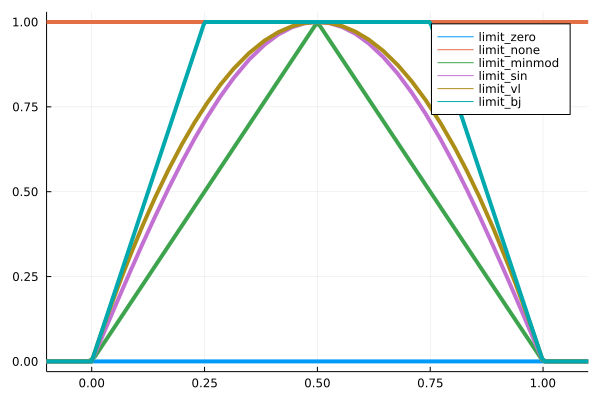

In [45]:
plot(limiters, label=limiters, xlims=(-.1, 1.1))

# A slope-limited solver

In [78]:
function fv_solve2(riemann, u_init, n, tfinal=1, limit=limit_sin)
    h = 2 / n
    x = LinRange(-1+h/2, 1-h/2, n) # cell midpoints (centroids)
    idxL = 1 .+ (n-1:2*n-2) .% n
    idxR = 1 .+ (n+1:2*n) .% n
    function rhs(t, u)
        jump = u[idxR] - u[idxL]
        r = (u - u[idxL]) ./ jump
        r[isnan.(r)] .= 0
        g = limit.(r) .* jump / 2h
        fluxL = riemann(u[idxL] + g[idxL]*h/2, u - g*h/2)
        fluxR = fluxL[idxR]
        (fluxL - fluxR) / h
    end
    thist, uhist = ode_rk_explicit(
        rhs, u_init.(x), h=h, tfinal=tfinal)
    x, thist, uhist
end

fv_solve2 (generic function with 3 methods)

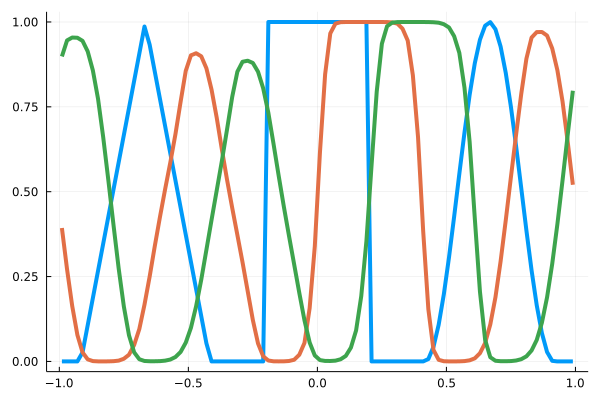

In [83]:
x, thist, uhist = fv_solve2(riemann_advection, testfunc, 100, .5,
    limit_sin)
plot(x, uhist[:,1:10:end], legend=:none)